# Perceptual Control B - Process Data

Note: this includes the logic for updating the database for excluded participants

In [1]:
import urllib.request
from functools import lru_cache
import datetime
import csv, json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from msdm.domains import GridWorld
from msdm.algorithms import PolicyIteration
from vgc_project import gridutils, sampsat

In [2]:
# load experiment parameters
expConfig = json.load(open("config.json", 'r'))
EXPERIMENT_CODE_VERSION = expConfig['params']['EXPERIMENT_CODE_VERSION']
cond1 = expConfig['timelines'][0]
basegrids = json.load(open("../mazes/mazes_0-11.json", "r"))

CREDENTIALS = json.load(open("../credentials.json", 'r'))
EXPURL = CREDENTIALS["EXPURL"]
USERNAME = CREDENTIALS["USERNAME"]
PASSWORD = CREDENTIALS["PASSWORD"]
print("Credentials:")
print(CREDENTIALS)

DESTDIR = "./data/"
if not os.path.exists(DESTDIR):
    os.mkdir(DESTDIR)
sourcedest = [
    (f"data/{EXPERIMENT_CODE_VERSION}/trialdata", DESTDIR+"rawtrialdata.csv"),
    (f"data/{EXPERIMENT_CODE_VERSION}/questiondata", DESTDIR+"rawquestiondata.csv"),
    (f"data/{EXPERIMENT_CODE_VERSION}/bonusdata", DESTDIR+"rawbonusdata.csv"),
    (f"data/{EXPERIMENT_CODE_VERSION}/conditiondata", DESTDIR+"rawconditiondata.csv")
]

password_mgr = urllib.request.HTTPPasswordMgrWithDefaultRealm()
password_mgr.add_password(None, EXPURL, USERNAME, PASSWORD)
handler = urllib.request.HTTPBasicAuthHandler(password_mgr)

In [3]:
for SOURCE, DEST in sourcedest:
    opener = urllib.request.build_opener(handler)
    opener.open(EXPURL+SOURCE)
    urllib.request.install_opener(opener)
    urllib.request.urlretrieve(EXPURL+SOURCE, DEST)   

In [4]:
csv.field_size_limit(sys.maxsize)
trialdata = [line for line in csv.reader(open(sourcedest[0][1], 'r'))]
questiondata = [line for line in csv.reader(open(sourcedest[1][1], 'r'))]
bonusdata = [line for line in csv.reader(open(sourcedest[2][1], 'r'))]
conditiondata = [line for line in csv.reader(open(sourcedest[3][1], 'r'))]

In [5]:
psiturk_conditions = pd.DataFrame(conditiondata, columns=['psiturk_id', 'condition'])

In [6]:
trials = []
errors = []
for psiturk_id, idx, datetime_ms, entry in trialdata:
    if "debug" in psiturk_id:
        continue
    datetime_ms = datetime.datetime.fromtimestamp(float(datetime_ms)/1000.)
    idx = int(idx)
    entry = json.loads(entry)
    try:
        assert idx == entry['trial_index']
    except AssertionError as e :
        errors.append((e, psiturk_id, idx, datetime_ms, entry))
    trials.append({
        "psiturk_id": psiturk_id,
        "idx": idx,
        "datetime_ms": datetime_ms,
        "data": entry.get("data", None),
        "trial_type": entry['trial_type'],
        "time_elapsed": entry['time_elapsed'],
        "internal_node_id": float(entry["internal_node_id"].split("-")[1])
    })
trials = pd.DataFrame(trials)
trials = trials[trials.psiturk_id.apply(lambda p: "debug" not in p)]

In [7]:
print(trials.groupby('psiturk_id')['internal_node_id'].max().value_counts())

144.0    89
104.0    84
12.0      7
5.0       6
4.0       2
11.0      1
Name: internal_node_id, dtype: int64


In [8]:
#dot trials
dot_trials = trials[(trials.trial_type == "GridWatchDot")]
dot_trials = dot_trials[(dot_trials.data.apply(lambda d: d['trialparams']['roundtype'] != "practice"))]
dot_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": dot_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame(list(dot_trials.data.apply(lambda d: {**d['trialparams'], **{k: v for k, v in d.items() if k not in ['trialparams', 'taskparams']}}).values))
], axis=1)
dot_trials['dot_duration_ms'] = dot_trials['dotAppearances'].apply(lambda da: da[0]['duration_ms'] if da else float('NaN'))
dot_trials = dot_trials[['original_gridname', 'original_sessionId', 'psiturk_id', 'sessionId', 'TRIAL_DURATION_MS', 'is_yoked', 'hasDot', 'grid', 
                         'transform', 'round', 'dotCatches', 'dotMisfires', 'dot_duration_ms']].reset_index(drop=True)
dot_trials.hasDot = dot_trials.hasDot.fillna(False)
dot_trials['correct'] = dot_trials.apply(lambda r: bool(r['dotCatches']) if r['hasDot'] else (r['dotMisfires'] == 0), axis=1)
dot_trials['bonus'] = dot_trials['correct']*.02
bonusdf = dot_trials[['psiturk_id', 'bonus']].reset_index(drop=True)

mean      0.832370
median    0.833333
sem       0.012836
Name: dotCatches, dtype: float64

(0.0, 1.0)

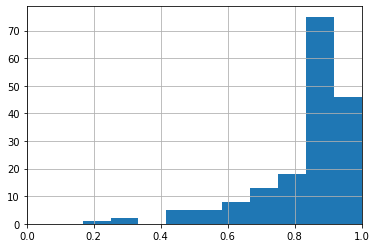

In [9]:
g = dot_trials[dot_trials['hasDot']].groupby("sessionId")['dotCatches'].mean().hist()
display(dot_trials[dot_trials['hasDot']].groupby("sessionId")['dotCatches'].mean().agg(['mean', 'median', 'sem']))
g.set_xlim(0, 1)

mean      0.100193
median    0.000000
sem       0.012762
Name: dotMisfires, dtype: float64

(0.0, 1.0)

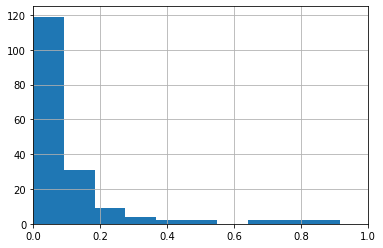

In [10]:
g = dot_trials[~dot_trials['hasDot']].groupby("sessionId")['dotMisfires'].apply(lambda dm: np.mean(dm > 0)).hist()
display(dot_trials[~dot_trials['hasDot']].groupby("sessionId")['dotMisfires'].apply(lambda dm: np.mean(dm > 0)).agg(['mean', 'median', 'sem']))
g.set_xlim(0, 1)

In [11]:
# dot_trials[dot_trials['hasDot']].groupby("sessionId")['dotMisfires'].apply(lambda dm: np.mean(dm > 0))

<AxesSubplot:xlabel='dot_duration_ms', ylabel='correct'>

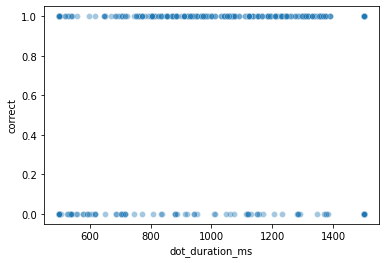

In [12]:
import seaborn as sns
sns.scatterplot(data=dot_trials[dot_trials.hasDot], x='dot_duration_ms', y='correct', alpha=.4)

In [13]:
original_sids = dot_trials[dot_trials['original_sessionId'].\
    apply(lambda sid: isinstance(sid, str))][['original_sessionId', 'sessionId', 'grid', 'round']].\
    reset_index(drop=True)

In [14]:
#awareness trials
attn_trials = trials[(trials.trial_type == "GridBlockAttentionQuery")]
attn_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": attn_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame(list(attn_trials.data.values))
], axis=1)
attn_trials['attn_resp'] = attn_trials['response'].apply(int)
attn_trials['attn_resp_N'] = (attn_trials['attn_resp'] - 1)/(8 - 1)
attn_trials['rt'] = attn_trials['responsetime'] - attn_trials['starttime']
attn_trials['obstacle'] = attn_trials['probeobs']
attn_trials['transform'] = attn_trials.navtrialparams.apply(lambda tp: tp['transform'])
attn_trials['grid'] = attn_trials.navtrialparams.apply(lambda tp: tp['grid'])
attn_trials = attn_trials[['psiturk_id', 'sessionId', 'grid', 'transform', 'round', 'starttime', 'responsetime',
                           'queryround', 'obstacle', 'rt', 'attn_resp', 'attn_resp_N']].reset_index(drop=True)
attn_trials = attn_trials.merge(original_sids, on=['sessionId', 'round', 'grid'], how='left')
round_count = attn_trials.groupby(['psiturk_id', 'sessionId'])['round'].count()
try:
    assert all(round_count == 8*5)
    pid_missing_data, sid_missing_data = set([]), set([])
except AssertionError:
    pid_missing_data, sid_missing_data = zip(*round_count[round_count != 12*7].index.values)
    pid_missing_data, sid_missing_data = set(pid_missing_data), set(sid_missing_data)
    print(f"Data missing for {len(pid_missing_data)} participants")
    display(round_count[round_count != 12*7].reset_index(name="rounds"))

In [15]:
#memory trials
GREEN = '#44A9A0'
YELLOW = "#DCCB5D"
mem_trials = trials[(trials.trial_type.isin(["CustomItem"]))]
mem_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": mem_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame(list(mem_trials.data.values))
], axis=1)
mem_trials['rt'] = mem_trials['responsetime'] - mem_trials['starttime']
mem_trials['true_color'] = mem_trials['true_color'].apply(lambda c: {YELLOW: 'Yellow', GREEN: "Green"}[c])
mem_trials = mem_trials[['psiturk_id', 'sessionId', 'round', 'roundtype', 'grid', 'transform', 
                           'probeobs', 'queryround', 'true_color', 'response', 'rt']].reset_index(drop=True)
mem_trials = mem_trials.pivot(index=['psiturk_id', 'sessionId', 'round', 'grid', 'transform', 'probeobs', 'queryround'], columns=['roundtype']).reset_index()
mem_trials["conf_rt"] = mem_trials[('rt', 'probe_conf')]
mem_trials["mem_rt"] = mem_trials[('rt', 'probe_2afc')]
mem_trials["conf"] = mem_trials[('response', 'probe_conf')].apply(int)
mem_trials["conf_N"] = (mem_trials["conf"] - 1)/(8 - 1)
mem_trials["correct"] = mem_trials[('true_color', 'probe_2afc')] == mem_trials[('response', 'probe_2afc')]
mem_trials["mem_resp"] = mem_trials[('response', 'probe_2afc')]
mem_trials["obstacle"] = mem_trials['probeobs']
mem_trials = mem_trials[['psiturk_id', 'sessionId', 'round', 'grid', 'transform', 'obstacle',
                         'queryround', 'mem_resp', 'correct', 'mem_rt', 'conf_rt', 'conf', 'conf_N']]
mem_trials.columns = mem_trials.columns.droplevel(level=1)
mem_trials = mem_trials.merge(original_sids, on=['sessionId', 'round', 'grid'], how='left')

In [16]:
assert len(original_sids)*5 == (len(mem_trials) + len(attn_trials))

In [17]:
#survey level data
survey_trials = trials[(trials.trial_type.isin(["CustomSurvey", "SaveGlobalStore"]))]
survey_trials = pd.concat([
    pd.DataFrame({
        "psiturk_id": survey_trials.psiturk_id,
    }).reset_index(drop=True),
    pd.DataFrame([d if d else {} for d in survey_trials.data.values])
], axis=1)
survey_trials = survey_trials.melt(id_vars='psiturk_id', var_name="question", value_name="response")
survey_trials = survey_trials[~survey_trials.response.isna()]
survey_trials = survey_trials.pivot(index='psiturk_id', columns="question" )
survey_trials.columns = survey_trials.columns.droplevel()
survey_trials = survey_trials.reset_index()
survey_trials.columns.name = None
survey_trials = survey_trials[survey_trials['playedGrid'].isin(["Yes", "No"])].reset_index(drop=True)
completed_task = survey_trials['psiturk_id']

In [18]:
for _, row in survey_trials.iterrows():
    if row.generalComments:
        print(row.sessionId)
        print(row.generalComments)
        print(row.gender)
        print()

40xLQJNJEa
it was rather interesting thank you for the invite.
male

1k9HyYZP1Z
None
Male

ld6YGHySM2
You keep saying the highlighted squares it would have been helpful to have had an example.
female

zTlKrPy3ai
my priority was the red dots
male

3mGaMb7ZoJ
I seem to always be guessing where the blue squares are, but I think I probably know where they are unconsciously since you are asking :)
female

Jjf0RT2Wx3
In all cases I was aware of the presence of blue tiles, but I didn't pay much attention to where they were, so it was difficult to say specifically which clusters of blue tiles I was more or less aware of.
Male

Yd1ETJMky2
I found this really hard!
Female

xMR6u4XhFj
that was hard and I don't think i got many right
female

U6DqLTVcHZ
This was a really hard task. Pressing for the red dot was fine but looking at the patterns on top was difficult 
female

EKKeYJnkrq
My strategy was just to scan the whole grid, and spot what's new (movement) - which (I think) helped me to find the r

In [19]:
survey_trials['exclude'] = survey_trials.playedGrid == "Yes"
pid_to_exclude, sid_to_exclude = survey_trials[['psiturk_id', 'sessionId']][survey_trials.playedGrid == "Yes"].values.T
pid_to_exclude = set(pid_to_exclude)
sid_to_exclude = set(sid_to_exclude)
assert len(sid_to_exclude) == len(pid_to_exclude)
all_pid = set([pid for pid, cond in conditiondata]) | (set(survey_trials.psiturk_id) | set(dot_trials.psiturk_id)) 
pid_no_data = all_pid - (set(survey_trials.psiturk_id) | set(dot_trials.psiturk_id)) 
print(f"Total Participants: {len(all_pid)}")
print(f"Participants with no data: {len(pid_no_data)}")
print(f"Participants with survey data: {len(survey_trials)}")
print(f"Participants who previously played task: {len(pid_to_exclude)}")
print(f"Participants missing data: {len(pid_missing_data)}")
print(f"Participants to Exclude: {len(pid_to_exclude | pid_missing_data)}")

Total Participants: 198
Participants with no data: 25
Participants with survey data: 173
Participants who previously played task: 1
Participants missing data: 0
Participants to Exclude: 1


In [20]:
# updates psiturk database to recruit conditions appropriately
# it is idempodent
for i, pid in enumerate(pid_to_exclude | pid_missing_data):
# for i, pid in enumerate(pid_to_exclude | pid_missing_data | pid_no_data):
    new_status = "ignore"
    print(i, pid)
    request = f"http://frozen-depths-23358.herokuapp.com/set_status?uniqueId={pid}&new_status={new_status}"
    res = urllib.request.urlopen(request).read()
    res = json.loads(res)
    if "success" not in res['status'].lower():
        print(res['status'], request)

0 60c33f3e6706eca45e689ea4:60d09311a72c688efd4c36a9


In [21]:
# save data before exclusions
survey_trials.to_json("./data/all-survey-trials.json")
attn_trials.to_json("./data/all-attention-trials.json")
mem_trials.to_json("./data/all-memory-trials.json")
dot_trials.to_json("./data/all-dot-trials.json")

# exclusions
survey_trials = survey_trials[~survey_trials.exclude].reset_index(drop=True)
attn_trials = attn_trials[attn_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
mem_trials = mem_trials[mem_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)
dot_trials = dot_trials[dot_trials.sessionId.isin(survey_trials.sessionId)].reset_index(drop=True)

# data after exclusions
# survey_trials.to_json("./data/survey-trials.json")
# attn_trials.to_json("./data/attention-trials.json")
# bc_trials.to_json("./data/nav-trials.json")

In [22]:
# final conditions counts (need 156)
survey_trials.condition.value_counts().value_counts()

1    140
2     16
Name: condition, dtype: int64

In [23]:
set(range(156)) - set(survey_trials.condition)

set()

In [24]:
assert all(mem_trials.groupby(['psiturk_id', 'round'])['conf'].count() == 5)
assert all(attn_trials.groupby(['psiturk_id', 'round'])['attn_resp'].count() == 5)

# Bonusing

In [25]:
pid_bonusdf = bonusdf.groupby('psiturk_id')['bonus'].sum().reset_index()
tot_b = 0
for _, r in pid_bonusdf.iterrows():
    b = max(r.bonus, 0) + .2
    if b == 0.0:
        continue
    tot_b += b
    print(f"{r.psiturk_id.split(':')[0]},{b:.2f}")
print(tot_b)
print(tot_b/len(pid_bonusdf))

551d8fccfdf99b51d1bea31e,0.64
5588b2bffdf99b7a7714efd1,0.68
55ac3198fdf99b6de3b68b23,0.60
55d5b77ddb6a810006fa05d5,0.58
55e57aa9c70c7a00102a598e,0.68
5630caf8733ea0000a162d0b,0.64
566feba6b937e400052d33b2,0.66
56a890b37f2472000b93763e,0.66
56b0b06fe8b6770005de04aa,0.58
56c9bd6310a82f000dffd6af,0.36
56d2fdff321cae000d68d946,0.56
56d56e550b5634000bdc5703,0.68
578b5e8ebaec1b0001696813,0.68
57ac85fec80df50001a5b25d,0.64
5932ccd3cf0d9600010e91c3,0.52
5932f5d4991e160001effbd2,0.56
5941588d81359000016787bd,0.64
59e879752f63d30001c8fb9f,0.64
59f8868e05d1d60001f1464d,0.66
5a2d5b44a15d1100014dad18,0.60
5a53d274ac56240001537a47,0.66
5a692a8463394a000155da61,0.56
5a840fcfb093f80001a7cf78,0.64
5aa7a5cc6475f90001a06c6c,0.66
5ae0c7d4e0feeb0001caff2b,0.62
5afdc329fca92600012695ca,0.56
5afde9de3eb22c00019bb6e3,0.68
5b0881a82e75960001b8b505,0.68
5b1f8feb44127b0001401d22,0.40
5bc08c345e8a950001892156,0.68
5bcf6b423a99c40001542fa1,0.48
5bd9eb1b1dcc41000132ae7e,0.60
5bfac2001cd5430001fc7aa1,0.68
5c129cc7ba